# Mamba Vision for Breast Cancer Detection

The Vision Mamba required a quite complicated computational environment setup, it might not be able to run in your local environment. For this case, you can try make a copy of this notebook on kaggle which has the required environment setup. 

Notebook: https://www.kaggle.com/code/astrohl/mamba-vision-for-healthcare 

## Data Processing

In [1]:
# Libraries
import os
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
from glob import glob
# /kaggle/input/breast-histopathology-images
imagePatches = glob('../input/breast-histopathology-images/**/**/*.png', recursive=True)

In [3]:
len(imagePatches)

1942668

In [4]:
import fnmatch
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)

In [5]:
classZero_set = set(classZero)
classOne_set = set(classOne)

y = [0 if img in classZero_set else 1 if img in classOne_set else None for img in imagePatches]

In [6]:
images_df = pd.DataFrame()

In [7]:
images_df["images"] = imagePatches
images_df["labels"] = y

In [8]:
images_df.groupby("labels")["labels"].count()

labels
0    1391166
1     551502
Name: labels, dtype: int64

In [9]:
sampled_df = images_df.sample(frac=0.02, random_state=42)
train, val = train_test_split(sampled_df, stratify=sampled_df.labels, test_size=0.2)
len(train), len(val) # qqq

(31082, 7771)

In [10]:
class MyDataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path,label = self.df[index]
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [11]:
# Transformations for the input images
batch_size = 16
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_dataset = MyDataset(df_data=train, transform=trans_train)
val_dataset = MyDataset(df_data=val,transform=trans_valid)

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset = val_dataset, batch_size=batch_size//2, shuffle=False, num_workers=0)

## Model Setup

In [12]:
!pip install mambavision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.5/446.5 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 8.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 92.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 kB 21.7 

In [13]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm  # Import tqdm for the progress bar
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
from mambavision import create_model

model = create_model('mamba_vision_T', pretrained=True, model_path="/tmp/mambavision_tiny_1k.pth.tar")
model.head = nn.Linear(in_features=model.head.in_features, out_features=1)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.45)
device = "cuda"
num_epochs = 5

train_loss_history = []
train_accuracy_history = []

100%|██████████| 364M/364M [00:08<00:00, 42.7MB/s] 


## Model Training

In [18]:
from tqdm import tqdm
from collections import OrderedDict
import gc
import os

save_dir = "/kaggle/working"
os.makedirs(save_dir, exist_ok=True)

msg = OrderedDict({"train_epoch": None, "loss": None, "acc": None, "val_loss": None, "val_acc": None})

def get_accuracy(preds, labels):
    return torch.sum((preds.flatten() > 0.5) == labels.to(device)) / labels.numel()

def train(epoch):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for i, (inputs, labels) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader))):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.unsqueeze(-1).to(device).float())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += get_accuracy(outputs, labels.to(device))
        
        if i % 10 == 0 and i > 0:
            msg.update({"train_epoch": epoch + 1, "loss": running_loss / (i + 1), "acc": (running_acc / (i + 1)).item()})
            pbar.set_postfix(**msg)

    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    return train_loss, train_acc


def validate():
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    for i, (inputs, labels) in enumerate(val_loader):
        with torch.no_grad():
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.unsqueeze(-1).to(device).float())
        val_loss += loss.item()
        val_acc += get_accuracy(outputs, labels.to(device))
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    scheduler.step()
    msg.update({"val_loss": val_loss, "val_acc": val_acc.item()})
    print(f"val_loss: {val_loss}, val_acc: {val_acc.item()}")
    return val_loss, val_acc.item()

In [19]:
# Memo Management
gc.collect()
torch.cuda.empty_cache()


metrics_history = [] 
model.to(device)
max_val_acc = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train(epoch)
    val_loss, val_acc = validate()  
    metrics_history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })
    
    print({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })
    
    model_path = os.path.join(save_dir, f"epoch_{epoch + 1}_valacc_{val_acc:.3f}.pt")
    torch.save(model.state_dict(), model_path)

    if val_acc > max_val_acc:
        max_val_acc = val_acc
        best_model_path = os.path.join(save_dir, f"best_model_{val_acc:.3f}.pt")
        torch.save(model.state_dict(), best_model_path)

print(metrics_history)

100%|██████████| 1943/1943 [06:52<00:00,  4.71it/s, acc=0.902, loss=0.235, train_epoch=1, val_acc=None, val_loss=None]


val_loss: 0.22846139183674208, val_acc: 0.9053497910499573
{'epoch': 0, 'train_loss': 0.23490768261407216, 'train_acc': tensor(0.9021, device='cuda:0'), 'val_loss': 0.22846139183674208, 'val_acc': 0.9053497910499573}


100%|██████████| 1943/1943 [06:53<00:00,  4.70it/s, acc=0.917, loss=0.204, train_epoch=2, val_acc=0.905, val_loss=0.228]


val_loss: 0.23507687410410616, val_acc: 0.9050925374031067
{'epoch': 1, 'train_loss': 0.20435811289525252, 'train_acc': tensor(0.9171, device='cuda:0'), 'val_loss': 0.23507687410410616, 'val_acc': 0.9050925374031067}


100%|██████████| 1943/1943 [06:51<00:00,  4.72it/s, acc=0.927, loss=0.185, train_epoch=3, val_acc=0.905, val_loss=0.235]


val_loss: 0.23905658619737047, val_acc: 0.9054783582687378
{'epoch': 2, 'train_loss': 0.1849906336313868, 'train_acc': tensor(0.9266, device='cuda:0'), 'val_loss': 0.23905658619737047, 'val_acc': 0.9054783582687378}


100%|██████████| 1943/1943 [06:53<00:00,  4.70it/s, acc=0.933, loss=0.174, train_epoch=4, val_acc=0.905, val_loss=0.239]


val_loss: 0.2492992893266664, val_acc: 0.897376537322998
{'epoch': 3, 'train_loss': 0.17420640399624898, 'train_acc': tensor(0.9327, device='cuda:0'), 'val_loss': 0.2492992893266664, 'val_acc': 0.897376537322998}


100%|██████████| 1943/1943 [06:51<00:00,  4.72it/s, acc=0.937, loss=0.167, train_epoch=5, val_acc=0.897, val_loss=0.249]


val_loss: 0.24676218633913655, val_acc: 0.9026491641998291
{'epoch': 4, 'train_loss': 0.16703365574918239, 'train_acc': tensor(0.9365, device='cuda:0'), 'val_loss': 0.24676218633913655, 'val_acc': 0.9026491641998291}
[{'epoch': 0, 'train_loss': 0.23490768261407216, 'train_acc': tensor(0.9021, device='cuda:0'), 'val_loss': 0.22846139183674208, 'val_acc': 0.9053497910499573}, {'epoch': 1, 'train_loss': 0.20435811289525252, 'train_acc': tensor(0.9171, device='cuda:0'), 'val_loss': 0.23507687410410616, 'val_acc': 0.9050925374031067}, {'epoch': 2, 'train_loss': 0.1849906336313868, 'train_acc': tensor(0.9266, device='cuda:0'), 'val_loss': 0.23905658619737047, 'val_acc': 0.9054783582687378}, {'epoch': 3, 'train_loss': 0.17420640399624898, 'train_acc': tensor(0.9327, device='cuda:0'), 'val_loss': 0.2492992893266664, 'val_acc': 0.897376537322998}, {'epoch': 4, 'train_loss': 0.16703365574918239, 'train_acc': tensor(0.9365, device='cuda:0'), 'val_loss': 0.24676218633913655, 'val_acc': 0.902649164

In [22]:
print(images_df.columns)
print(sampled_df.columns)


Index(['images', 'labels'], dtype='object')
Index(['images', 'labels'], dtype='object')


In [20]:
metrics_df = pd.DataFrame(metrics_history)

csv_path = "/kaggle/working/metrics_history.csv"
metrics_df.to_csv(csv_path, index=False)

print(f"Metrics history saved to {csv_path}")

Metrics history saved to /kaggle/working/metrics_history.csv


In [23]:
remaining_df = images_df[~images_df['images'].isin(sampled_df['images'])]
sampled_df = remaining_df.sample(frac=0.005, random_state=42)
trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_dataset = MyDataset(df_data=sampled_df,transform=trans_valid)

test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [24]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def test_model(test_loader, model, criterion, device):
    model.eval() 
    test_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.sigmoid(outputs).squeeze(-1)  
            preds = (probs > 0.5).long()
            
            loss = criterion(outputs.squeeze(-1), labels.float())
            test_loss += loss.item()
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    test_loss /= len(test_loader)
    auc = roc_auc_score(all_labels, all_probs)
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test AUC: {auc:.4f}")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test F1-score: {f1:.4f}")
    
    return {
        "loss": test_loss,
        "auc": auc,
        "accuracy": acc,
        "recall": recall,
        "precision": precision,
        "f1": f1
    }

test_metrics = test_model(test_loader, model, criterion, device)


Test Loss: 0.2638
Test AUC: 0.9532
Test Accuracy: 0.8965
Test Recall: 0.8144
Test Precision: 0.8229
Test F1-score: 0.8186


In [ ]:
from sklearn.metrics import roc_auc_score
model.to(device)
model.load_state_dict(torch.load("/kaggle/input/66666666666666666666666/as_model_0.968.pt", map_location=torch.device('cpu')))
model.eval()#aaaaaaaaaaaaaaaaa

In [29]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm  # Import tqdm for the progress bar
import seaborn as sns
import matplotlib.pyplot as plt

outputs = []
y_true = []
for i, (inputs, labels) in enumerate(val_loader):
    with torch.no_grad():
        outputs.append(model(inputs.to(device)).flatten().cpu().numpy())
        y_true.append(labels.numpy())
preds = (np.concatenate(outputs) > 0.5).astype(int)
outputs = np.concatenate(outputs)
y_true = np.concatenate(y_true)

## Visualizations

APCER 0.05094509450945094
BPCER 0.213898916967509
ACER 0.13242200573847998
FRR 0.213898916967509
FAR 0.05094509450945094
HTER 0.13242200573847998
ROC AUC score: 0.9577167283515355
EER: 0.10585058505850585
F1 score: 0.8215043621787315
Precision score: 0.860246913580247
Recall score: 0.7861010830324909


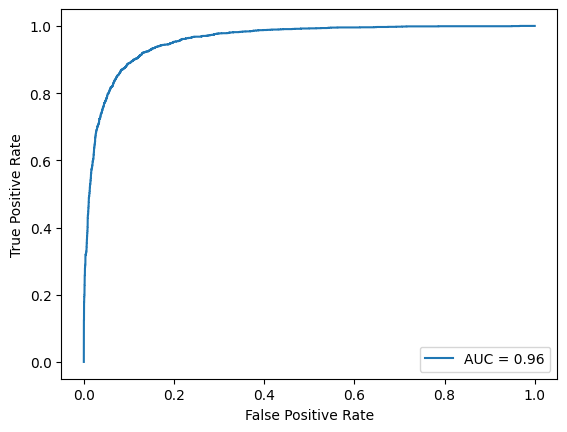

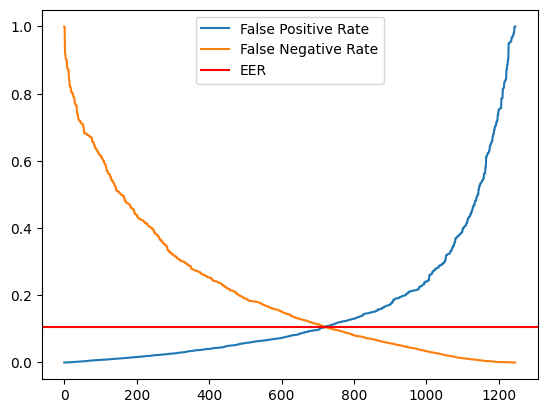

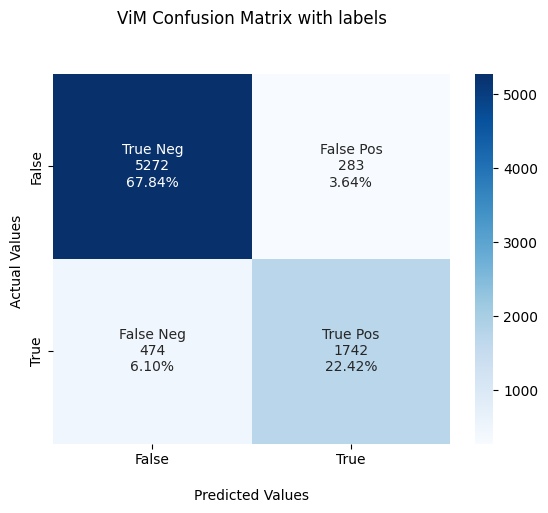

In [33]:
from sklearn.metrics import roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt


tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

apcer = fp/(tn + fp)
bpcer = fn/(fn + tp)
acer = (apcer + bpcer) / 2.0
frr = fn/(fn + tp)
far = fp/(fp + tn)
hter = (frr + far) / 2.0

print('APCER', apcer)
print('BPCER', bpcer)
print('ACER', acer)
print('FRR', frr)
print('FAR', far)
print('HTER', hter)

fpr, tpr, threshold = roc_curve(y_true, outputs, pos_label=1)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("ROC AUC score:", roc_auc_score(y_true, outputs))
print("EER:", EER)
print("F1 score:", metrics.f1_score(y_true, preds))
print("Precision score:", metrics.precision_score(y_true, preds))
print("Recall score:", metrics.recall_score(y_true, preds))

fpr, tpr, thresholds = metrics.roc_curve(y_true, outputs)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
display.plot()
plt.show()
plt.plot(fpr, label="False Positive Rate")
fnr = 1 - tpr
plt.plot(fnr, label="False Negative Rate")
plt.axhline(y=EER, label="EER", color='r', linestyle='-')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns


cf_matrix = confusion_matrix(y_true, preds)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
ax.set_title('ViM Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaa